<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git

In [3]:
#!rm -rf GEOMAR-DeepLearning/
#!ls -l

In [4]:
%ls -l

total 8
drwxr-xr-x 4 root root 4096 Feb 26 13:27 GEOMAR-DeepLearning/
drwxr-xr-x 1 root root 4096 Feb 21 14:21 sample_data/


In [5]:
import os
if not os.path.exists('GEOMAR-DeepLearning'):
    print(f'GEOMAR-DeepLearning does not exist')
    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
    %cd GEOMAR-DeepLearning/app/backend
    !pip install -r requirements.txt
else:
    print(f'GEOMAR-DeepLearning exists')
    %cd GEOMAR-DeepLearning/app/backend
    !pip install -r requirements.txt

GEOMAR-DeepLearning exists
/content/GEOMAR-DeepLearning/app/backend


In [6]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus




# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [7]:
START_DATE = '2025-02-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [8]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"]):

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=OUTPUT_FILENAME)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"]
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"]
)

INFO - 2025-02-26T14:56:26Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-02-26T14:56:26Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-02-26T14:56:42Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/330 [00:00<?, ?it/s]

INFO - 2025-02-26T14:58:01Z - Successfully downloaded to output.nc
INFO:copernicusmarine:Successfully downloaded to output.nc
INFO - 2025-02-26T14:58:03Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-02-26T14:58:03Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-02-26T14:58:10Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/2 [00:00<?, ?it/s]

INFO - 2025-02-26T14:58:11Z - Successfully downloaded to output.nc
INFO:copernicusmarine:Successfully downloaded to output.nc


## IDA

In [9]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [10]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657435 entries, 0 to 657434
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       657435 non-null  datetime64[ns]
 1   depth      657435 non-null  float32       
 2   latitude   657435 non-null  float32       
 3   longitude  657435 non-null  float32       
 4   bottomT    657435 non-null  float32       
 5   mlotst     657435 non-null  float32       
 6   siconc     657435 non-null  float32       
 7   sithick    657435 non-null  float32       
 8   sla        657435 non-null  float32       
 9   so         657435 non-null  float32       
 10  sob        657435 non-null  float32       
 11  thetao     657435 non-null  float32       
 12  uo         657435 non-null  float32       
 13  vo         657435 non-null  float32       
 14  wo         657435 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 40.1 MB


None

In [11]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2025-02-01 00:00:00,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       615 non-null    datetime64[ns]
 1   latitude   615 non-null    float32       
 2   longitude  615 non-null    float32       
 3   sla        615 non-null    float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 12.1 KB


None

array([54.358276], dtype=float32)

In [12]:
df_merged = pd.merge(training_data, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657435 entries, 0 to 657434
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   time              657435 non-null  datetime64[ns]
 1   depth             657435 non-null  float32       
 2   latitude          657435 non-null  float32       
 3   longitude         657435 non-null  float32       
 4   bottomT           657435 non-null  float32       
 5   mlotst            657435 non-null  float32       
 6   siconc            657435 non-null  float32       
 7   sithick           657435 non-null  float32       
 8   sla               657435 non-null  float32       
 9   so                657435 non-null  float32       
 10  sob               657435 non-null  float32       
 11  thetao            657435 non-null  float32       
 12  uo                657435 non-null  float32       
 13  vo                657435 non-null  float32       
 14  wo  

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
count,657435,657435.000000,657435.000000,657435.000000,657435.000000,657435.000000,6.574350e+05,6.574350e+05,657435.000000,657435.000000,657435.000000,657435.000000,657435.000000,657435.000000,6.574350e+05,657435.000000,657435.000000,657435.000000
mean,2025-02-13 19:00:00.000000256,0.501646,54.660542,10.454241,3.943158,10.474827,3.838736e-08,3.284988e-07,-0.212865,15.350955,19.256872,3.306167,-0.030863,0.058617,-3.114878e-07,54.358334,10.152695,-0.218465
min,2025-02-01 00:00:00,0.501646,54.308277,9.874912,-0.591978,2.274687,0.000000e+00,0.000000e+00,-0.921992,8.571222,8.571222,-0.799094,-0.898166,-1.230932,-2.172987e-04,54.358276,10.152689,-0.816700
25%,2025-02-07 09:00:00,0.501646,54.524940,10.208244,3.517178,9.892654,0.000000e+00,0.000000e+00,-0.380983,13.234268,18.901932,2.921834,-0.081226,-0.020449,-5.698962e-11,54.358276,10.152689,-0.408219
50%,2025-02-13 19:00:00,0.501646,54.658272,10.458243,3.898199,10.018637,0.000000e+00,0.000000e+00,-0.199440,15.662222,19.686647,3.361988,-0.016506,0.023991,3.856677e-07,54.358276,10.152689,-0.203643
75%,2025-02-20 05:00:00,0.501646,54.791603,10.680465,4.448705,10.156949,0.000000e+00,0.000000e+00,-0.041065,17.814398,20.381387,3.771590,0.028869,0.090744,1.461895e-06,54.358276,10.152689,-0.030179
max,2025-02-26 14:00:00,0.501646,54.958267,10.902686,7.357439,33.155102,1.039391e-02,9.997947e-02,0.236108,20.839090,23.257256,4.939826,0.761376,1.805505,5.789600e-05,54.358276,10.152689,0.213716
std,NaN,0.001464,0.258245,0.276950,0.732489,2.841136,1.894076e-05,1.752822e-04,0.211749,2.953095,2.153546,0.639598,0.119939,0.179207,9.936452e-06,0.149923,0.033144,0.227800


## EDA

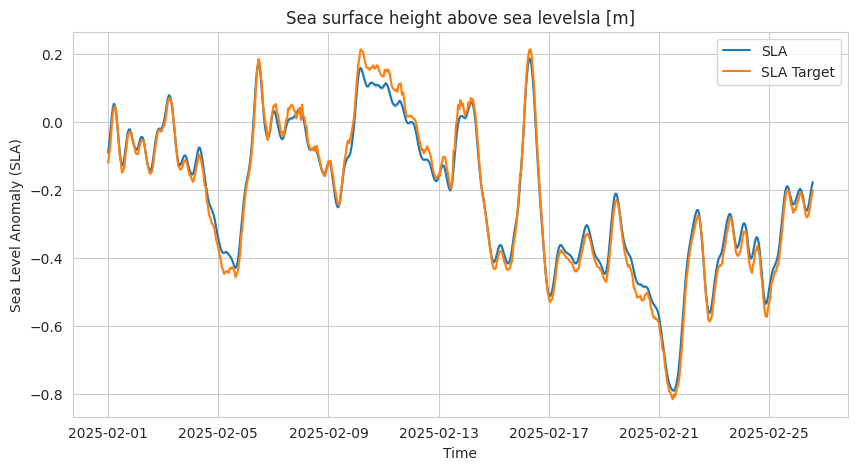

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn
sns.set_style("whitegrid")

# Erstellen der Plot-Figur
plt.figure(figsize=(10, 5))

# Plot der SLA-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla"], label="SLA")

# Plot der SLA Target-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla_target"], label="SLA Target")

# Achsen und Titel setzen
plt.title("Sea surface height above sea levelsla [m]")
plt.xlabel("Time")
plt.ylabel("Sea Level Anomaly (SLA)")

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


# Stationary

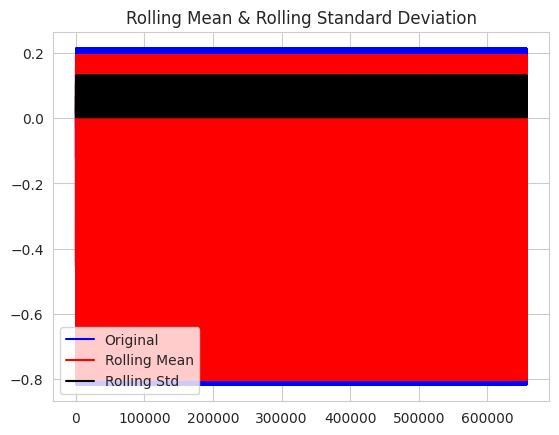

In [14]:
df_target = df_merged["sla_target"]

rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
plt.plot(df_target, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [15]:

"""
from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\ndef print_df_stats(series, order):\n    x=series\n    if (order>0):\n        x=x.diff(order)[order:]\n    result = adfuller(x)\n    print('ADF Statistic: {}'.format(result[0]))\n    print('p-value: {}'.format(result[1]))\n    print('Critical Values:')\n    for key, value in result[4].items():\n        print('\t{}: {}'.format(key, value))\n\nprint_df_stats(df_target, 0)\nprint_df_stats(df_target, 1)\n"

In [16]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

In [17]:
cols = [col for col in df_merged.columns if df_merged[col].dtype in [np.float64, np.float32]]
cols

['depth',
 'latitude',
 'longitude',
 'bottomT',
 'mlotst',
 'siconc',
 'sithick',
 'sla',
 'so',
 'sob',
 'thetao',
 'uo',
 'vo',
 'wo',
 'latitude_target',
 'longitude_target',
 'sla_target']

## Shaping the data to a picture

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Assuming 'df' is your DataFrame
df = df_merged.copy()
# 1. Convert time to datetime (if not already)
df['time'] = pd.to_datetime(df['time'])

# Round latitudes and longitudes
df['latitude'] = df['latitude']
df['longitude'] = df['longitude']

# 2. Get unique time points (hourly)
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

df = df.drop(columns=["sla_target", "sla", "latitude_target", "longitude_target"])
target = df_merged["sla_target"]

display(df.head(3))
display(df.info())

print(f'Number of Unique latituds: {len(df["latitude"].unique())}')
print(f'Number of Unique longitudes: {len(df["longitude"].unique())}')

# 3. Create function to map lat/lon to grid coordinates
def map_coordinates_to_grid(df):
    # Get unique latitudes and longitudes
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()

    # Create a grid, map latitude/longitude to a 2D grid
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    #print(latitude_map)
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# 4. Create RGB image for each hour
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):


    # get cols wich are numerical
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]

    # Remove latitude and longitude from cols
    cols.remove('latitude')
    cols.remove('longitude')
    #print(cols)

    # Normalize the values of uo, wo, and vo to [0, 255]
    #scaler = MinMaxScaler((0, 255))
    #df[cols] = scaler.fit_transform(df[cols])

    # Initialize a 2D array for every feature
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)

    for _, row in df.iterrows():
        #print(row)
        #print(row['latitude'])
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]

        # Assign values of the cols to the corresponding pixel
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]

    return image

learning_data = {}
# 5. Loop through each unique time point and create an image
for i, time_point in enumerate(unique_times):
    # Filter data for the given time
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]

    # Map coordinates to grid
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)

    # Create RGB image for this timepoint
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)

    learning_data[time_point] = np.array(image)

    """
    # Save or display the image
    plt.imshow(image)
    plt.title(f'Image for {time_point}')
    plt.axis('off')  # Turn off axis labels
    #plt.savefig(f'image_{time_point}.png')  # Save the image
    plt.show()
    """

    #print(image.shape)
    if i >= 2:
      break

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657435 entries, 0 to 657434
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       657435 non-null  datetime64[ns]
 1   depth      657435 non-null  float32       
 2   latitude   657435 non-null  float32       
 3   longitude  657435 non-null  float32       
 4   bottomT    657435 non-null  float32       
 5   mlotst     657435 non-null  float32       
 6   siconc     657435 non-null  float32       
 7   sithick    657435 non-null  float32       
 8   so         657435 non-null  float32       
 9   sob        657435 non-null  float32       
 10  thetao     657435 non-null  float32       
 11  uo         657435 non-null  float32       
 12  vo         657435 non-null  float32       
 13  wo         657435 non-null  float32       
dtypes: datetime64[ns](1), float32(13)
memory usage: 37.6 MB


None

Number of Unique latituds: 40
Number of Unique longitudes: 38


In [46]:
print(len(learning_data))

3


In [48]:
learning_data = list(learning_data.values())
learning_data = np.array(learning_data)
print(learning_data.shape)

(3, 40, 38, 11)
